#Setup

In [18]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglu1-mesa
  libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev
  libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev
  libsm-dev libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 49 not upgraded.
Need t

In [19]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env


#Environment

In [20]:
def seasonal_duck_curve(hour, season, noise_scale=0.03):
    """ Computes electricity demand based on seasonal duck curve """
    A = 400
    seasonal_params = {
        1: (100, 7, 80, 12, 120, 14, 250, 18, 30, 4),  # Summer
        2: (180, 6, 40, 12, 80, 14, 220, 17, 60, 4),  # Winter
        3: (130, 7, 90, 12, 100, 14, 180, 18, 40, 4)  # Spring/Autumn
    }
    B, t_morning, C, t_dip, D, mu_dip, E, t_evening, F, t_early = seasonal_params[season]
    demand = A + B / (1 + np.exp(-1 * (hour - t_morning))) - C / (1 + np.exp(-1 * (hour - t_dip))) - D * np.exp(-((hour - mu_dip)**2) / 4) + E / (1 + np.exp(-1 * (hour - t_evening)))
    return demand * random.uniform(0.9, 1.1)

def electricity_price_function(hour, season, demand, noise_scale=0.03):
    """ Computes electricity price based on seasonal demand """
    season_params = {
        1: (30, 15, 10),  # Summer
        2: (28, 14, 9),   # Winter
        3: (25, 12, 8)    # Spring/Autumn
    }
    A_q, B_q, C_q = season_params[season]
    base_price = A_q + B_q * np.cos(2 * np.pi * hour / 24) + C_q * np.cos(4 * np.pi * hour / 24)
    return max(base_price * random.uniform(0.9, 1.1), 0)


In [21]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

class ElectricityMarketEnv(gym.Env):
    """
    Custom Gym environment for an electricity market with battery storage.
    The agent decides when to charge/discharge to maximize profit.
    """
    def __init__(self, max_timesteps=365, degradation_rate=0.99, season = None):
        super(ElectricityMarketEnv, self).__init__()
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.one_season = season
        if self.one_season is not None:
          self.season = self.one_season
        else:
          self.season = self.get_season_from_timestep(0)  # Set initial season based on real months
        self.episode_count = 0  # Track training episodes
        self.degradation_rate = degradation_rate  # Battery degradation factor

        # Battery parameters
        self.initial_battery_capacity = 100  # Initial max storage capacity
        self.battery_capacity = self.initial_battery_capacity  # Maximum storage capacity
        self.battery_soc = 50  # Initial state of charge (SoC)
        self.efficiency = 0.95  # Charging/discharging efficiency

        # Electricity market parameters
        self.base_min_price, self.base_max_price = self._calculate_price_bounds()
        self.base_min_demand, self.base_max_demand = self._calculate_demand_bounds()

        self.min_price, self.max_price = self.base_min_price * 0.9, self.base_max_price * 1.1
        self.min_demand, self.max_demand = self.base_min_demand * 0.9, self.base_max_demand * 1.1


        # Action space: Charge (+) or discharge (-) within battery capacity
        self.action_space = spaces.Box(low=-self.battery_capacity, high=self.battery_capacity, shape=(1,), dtype=np.float32)

        # Observation space: [Battery SoC, Battery Capacity, Electricity Price, Demand, Hour, Season]
        self.observation_space = spaces.Box(
            low=np.array([0, 50, self.min_price, self.min_demand, 0, 1], dtype=np.float32),
            high=np.array([self.initial_battery_capacity, self.initial_battery_capacity, self.max_price, self.max_demand, 23, 3], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.battery_capacity = self.initial_battery_capacity  # Reset battery capacity
        self.timestep = 0
        self.battery_soc = 50  # Reset battery SoC
        if self.one_season is not None:
          self.season = self.one_season
        else:
          self.season = self.get_season_from_timestep(0)   # Set season dynamically
        self.episode_count += 1  # Track episode count
        return self._get_state(), {}

    def step(self, action):
        """
        Executes one step in the environment.
        Action: Charge (>0) or discharge (<0) electricity.
        """
        self.timestep += 1
        if self.one_season is None:
          self.season = self.get_season_from_timestep(0)
        done = self.timestep >= self.max_timesteps or self.battery_soc <= 0

        self.battery_capacity *= self.degradation_rate
        self.battery_capacity = max(self.battery_capacity, 50)  # Minimum capacity limit

        # Get new price and demand based on season
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)

        # Clip action to valid range (-battery_capacity, +battery_capacity)
        action = np.clip(action[0], -self.battery_capacity, self.battery_capacity)

        # Charge/discharge the battery
        if action > 0:  # Charging (cost money)
            charge_amount = min(action, self.battery_capacity - self.battery_soc)
            cost = charge_amount * price / self.efficiency
            self.battery_soc += charge_amount * self.efficiency
            reward = -cost  # Negative reward for spending money
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Charging {charge_amount:.2f} units at price {price:.2f}. Cost: {cost:.2f}. SoC: {self.battery_soc:.2f}.")
        else:  # Discharging (sell to market)
            discharge_amount = min(-action, self.battery_soc, demand)
            revenue = discharge_amount * price * self.efficiency
            self.battery_soc -= discharge_amount / self.efficiency
            reward = revenue  # Positive reward for selling
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Discharging {discharge_amount:.2f} units at price {price:.2f}. Revenue: {revenue:.2f}. SoC: {self.battery_soc:.2f}.")

        next_state = np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)
        return next_state, reward, done, False, {}

    def _get_state(self):
        """ Returns the current state: [SoC, Price, Demand, Hour, Season] """
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)
        #print(f"State - SoC: {self.battery_soc:.2f}, Price: {price:.2f}, Demand: {demand:.2f}, Hour: {hour}, Season: {self.season}.")
        return np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)



    def get_season_from_timestep(self, timestep):
        """ Determines season based on day of the year """
        month = (timestep // 30) % 12  # Approximate month from timestep
        if month in [11, 0, 1]:
            return 2  # Winter
        elif month in [5, 6, 7]:
            return 1  # Summer
        else:
            return 3  # Spring/Autumn

    def get_season_name(self, season):
        return {1: "Summer", 2: "Winter", 3: "Spring/Autumn"}.get(season, "Unknown")


    def evaluate_agent(self, agent, num_episodes=3):
        """ Evaluates the agent over multiple episodes and prints performance metrics per season. """
        total_rewards = []
        season_rewards = {1: [], 2: [], 3: []}

        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            seasonal_reward = {1: 0, 2: 0, 3: 0}

            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
                seasonal_reward[self.season] += reward

            total_rewards.append(episode_reward)
            for season in seasonal_reward:
                season_rewards[season].append(seasonal_reward[season])

            print(f"Episode {ep + 1}: Total Reward = {episode_reward:.2f}")

        avg_reward = np.mean(total_rewards)
        avg_seasonal_rewards = {season: np.mean(rewards) if rewards else 0 for season, rewards in season_rewards.items()}

        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Seasonal Performance:")
        for season, avg in avg_seasonal_rewards.items():
            print(f"  {self.get_season_name(season)}: {avg:.2f}")

        return avg_reward, avg_seasonal_rewards

    def _calculate_price_bounds(self):
        """ Determine min/max price dynamically based on electricity_price_function """
        min_price = float('inf')
        max_price = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                price = electricity_price_function(hour, season, demand)
                min_price = min(min_price, price)
                max_price = max(max_price, price)
        return min_price, max_price

    def _calculate_demand_bounds(self):
        """ Determine min/max demand dynamically based on seasonal_duck_curve """
        min_demand = float('inf')
        max_demand = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                min_demand = min(min_demand, demand)
                max_demand = max(max_demand, demand)
        return min_demand, max_demand



In [22]:
env = ElectricityMarketEnv()
obs, _ = env.reset()



#Evaluation Functions


In [23]:
from stable_baselines3.common.evaluation import evaluate_policy


In [24]:
%pip install tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
import time
import numpy as np
import tensorflow as tf
from stable_baselines3.common.callbacks import BaseCallback

class RLComparisonCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RLComparisonCallback, self).__init__(verbose)
        self.start_time = time.time()

    def _on_training_start(self) -> None:
        self.episode_rewards = []
        self.episode_lengths = []
        self.total_timesteps = 0

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None:
            for done, reward, info in zip(self.locals["dones"], self.locals["rewards"], self.locals["infos"]):
                if done:
                    episode_reward = info.get("episode", {}).get("r", reward)
                    episode_length = info.get("episode", {}).get("l", 0)

                    self.episode_rewards.append(episode_reward)
                    self.episode_lengths.append(episode_length)
                    self.total_timesteps += episode_length

                    # Logging metrics after each episode using log scale
                    avg_reward = np.mean(self.episode_rewards[-100:])
                    cum_reward = np.sum(self.episode_rewards)
                    discounted_reward = np.sum([r * (0.99 ** i) for i, r in enumerate(self.episode_rewards)])
                    convergence_rate = np.std(self.episode_rewards[-100:])
                    sample_efficiency = cum_reward / max(1, self.total_timesteps)
                    stability = np.std(self.episode_rewards)
                    policy_entropy = info.get('entropy', 0)
                    time_complexity = time.time() - self.start_time
                    space_complexity = self.model.policy.parameters_to_vector().nbytes

                    self.logger.record("custom/average_reward", avg_reward)
                    self.logger.record("custom/cumulative_reward", cum_reward)
                    self.logger.record("custom/discounted_reward", discounted_reward)
                    self.logger.record("custom/convergence_rate", convergence_rate)
                    self.logger.record("custom/sample_efficiency", sample_efficiency)
                    self.logger.record("custom/stability", stability)
                    self.logger.record("custom/policy_entropy", policy_entropy)
                    self.logger.record("custom/time_complexity", time_complexity)
                    self.logger.record("custom/space_complexity", space_complexity)

        return True


#Lets start with training

In [26]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DDPG

In [27]:
from stable_baselines3.common.callbacks import CheckpointCallback, CallbackList

In [28]:

def get_rewards(
    model,
    num_episodes: int = 100,
    deterministic: bool = True,
) -> float:
    # This function will only work for a single environment
    vec_env = PPO("MlpPolicy", env, learning_rate=np.random.uniform(1e-5, 1e-3), verbose=0).get_env()
    obs = vec_env.reset()
    all_episode_rewards = []
    for _ in range(num_episodes):
        episode_rewards = []
        done = False
        while not done:
            # _states are only useful when using LSTM policies
            # `deterministic` is to use deterministic actions
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, _info = vec_env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))
    return all_episode_rewards

In [29]:
def evaluate(
    model,
    num_episodes: int = 100,
    deterministic: bool = True,
) -> float:
  all_episode_rewards = get_rewards(model, num_episodes, deterministic)
  mean_episode_reward = np.mean(all_episode_rewards)
  print(f"Mean reward: {mean_episode_reward:.2f} - Num episodes: {num_episodes}")
  return mean_episode_reward


#PPO

In [30]:
env.evaluate_agent(ppo_model, num_episodes=365)

Episode 1: Total Reward = 4995.12
Episode 2: Total Reward = 6736.35
Episode 3: Total Reward = 4887.91
Episode 4: Total Reward = 6755.79
Episode 5: Total Reward = 4297.13
Episode 6: Total Reward = 6075.68
Episode 7: Total Reward = 6320.69
Episode 8: Total Reward = 5285.54
Episode 9: Total Reward = 4688.51
Episode 10: Total Reward = 6155.73
Episode 11: Total Reward = 5094.28
Episode 12: Total Reward = 4119.86
Episode 13: Total Reward = 5849.09
Episode 14: Total Reward = 6159.37
Episode 15: Total Reward = 4158.37
Episode 16: Total Reward = 4297.68
Episode 17: Total Reward = 5152.62
Episode 18: Total Reward = 4821.55
Episode 19: Total Reward = 4671.17
Episode 20: Total Reward = 6430.02
Episode 21: Total Reward = 7125.44
Episode 22: Total Reward = 5057.08
Episode 23: Total Reward = 5607.23
Episode 24: Total Reward = 6765.28
Episode 25: Total Reward = 5957.85
Episode 26: Total Reward = 5392.44
Episode 27: Total Reward = 5752.89
Episode 28: Total Reward = 4812.13
Episode 29: Total Reward = 58

(5823.267393255157, {1: 0.0, 2: 5823.267393255157, 3: 0.0})

#Season Comparison


In [31]:
SEEDS = [22]
steps = [200000, 500000, 1000000]

In [32]:
summer_env = ElectricityMarketEnv(season=1, max_timesteps=91)
winter_env = ElectricityMarketEnv(season=2, max_timesteps=91)
spring_env = ElectricityMarketEnv(season=3, max_timesteps=91)

In [33]:
from stable_baselines3.common.vec_env import DummyVecEnv
model_type = "PPO"
for seed in SEEDS:
  for step in steps:
    for season_env, name in zip([summer_env, winter_env, spring_env], ["summer", "winter", "spring"]):
      season_env.reset(seed=seed)
      ppo_model = PPO("MlpPolicy", season_env, verbose=0, tensorboard_log="./tensorboard/",  seed=seed).learn(step, tb_log_name=f"{model_type}_{seed}_{step}", progress_bar=True)
      ppo_model.save(f"./models_by_season/{model_type}_{seed}_{step}_{name}")
      print(f"{model_type}_{seed}_{step}_{name}")

Output()

KeyboardInterrupt: 

In [34]:
def get_season(t):
  if 182 <= t <= 243:
    return 1  # Summer (July-August)
  elif 335 <= t or t <= 59:
    return 2  # Winter (December-February)
  else:
    return 3  # Spring/Autumn (March-June, Sept-Nov)

In [35]:
from typing_extensions import Self
class FourSeasonModel():
  def __init__(self, winter, summer, spring, env) -> None:
      self.winter = winter
      self.summer = summer
      self.spring = spring
      self.env = env
      self.time = 1

  def get_env(self):
    return self.env


  def predict(self, obs, deterministic=True):
    season = get_season(self.time)
    if season == 1:
      return self.summer.predict(obs, deterministic=deterministic)
    elif season == 2:
      return self.winter.predict(obs, deterministic=deterministic)
    else:
      return self.spring.predict(obs, deterministic=deterministic)
    self.time += 1
    if self.time == 366:
      self.time = 1

In [37]:
ppo_spring = PPO.load("models_by_season/PPO_22_200000_summer")
ppo_summer = PPO.load("models_by_season/PPO_22_200000_winter")
ppo_winter = PPO.load("models_by_season/PPO_22_200000_spring")
env.reset()
ppo_4season = FourSeasonModel(ppo_winter, ppo_summer, ppo_spring, env)
ppo_4season_mean_2 = evaluate(ppo_4season)

ppo_spring = PPO.load("models_by_season/PPO_22_500000_summer")
ppo_summer = PPO.load("models_by_season/PPO_22_500000_winter")
ppo_winter = PPO.load("models_by_season/PPO_22_500000_spring")
env.reset()
ppo_4season = FourSeasonModel(ppo_winter, ppo_summer, ppo_spring, env)
ppo_4season_mean_5 = evaluate(ppo_4season)

ppo_spring = PPO.load("models_by_season/PPO_22_1000000_summer")
ppo_summer = PPO.load("models_by_season/PPO_22_1000000_winter")
ppo_winter_10 = PPO.load("models_by_season/PPO_22_1000000_spring")
env.reset()
ppo_4season = FourSeasonModel(ppo_winter, ppo_summer, ppo_spring, env)
ppo_4season_mean = evaluate(ppo_4season)

yearly_ppo = PPO.load("PPO_2_1000000")
yearly_ppo_mean = evaluate(yearly_ppo)

Mean reward: 1510.19 - Num episodes: 100

Mean reward: 1826.31 - Num episodes: 100

Mean reward: 1826.31 - Num episodes: 100

Mean reward: 5492.71 - Num episodes: 100

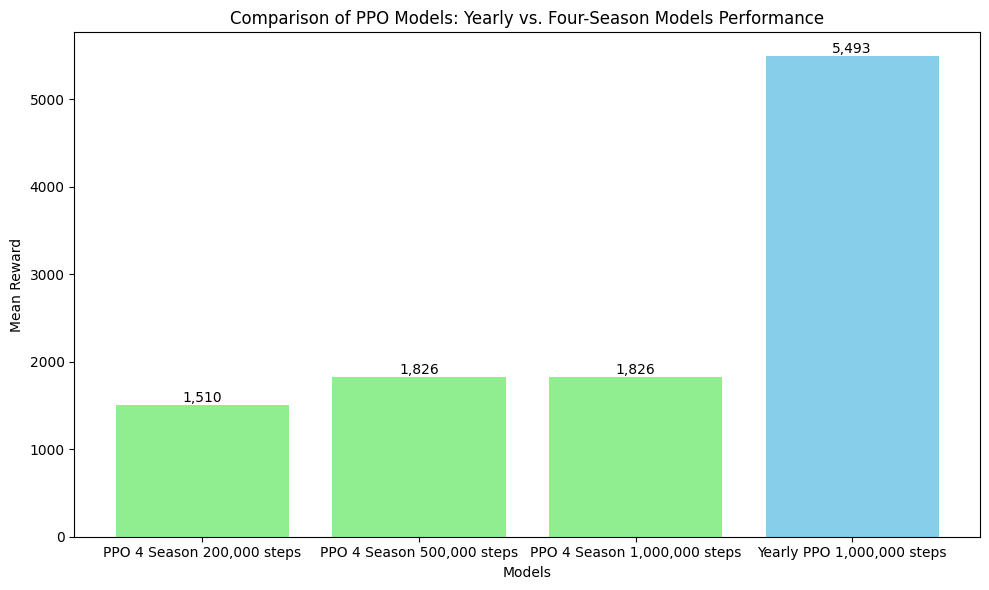

In [41]:
import matplotlib.pyplot as plt

# Mean rewards for the different models (ensure they are properly assigned)
mean_rewards = {
    "PPO 4 Season 200,000 steps": ppo_4season_mean_2,  # replace with actual mean value
    "PPO 4 Season 500,000 steps": ppo_4season_mean_5,  # replace with actual mean valu
    "PPO 4 Season 1,000,000 steps": ppo_4season_mean,  # replace with actual mean value
    "Yearly PPO 1,000,000 steps": yearly_ppo_mean,  # replace with actual mean value
}

# Assign distinct colors for yearly vs. 4 season models
colors = {
    model: 'skyblue' if '4 Season' not in model else 'lightgreen'
    for model in mean_rewards.keys()
}

# Plotting the results
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_rewards.keys(), mean_rewards.values(), color=[colors[model] for model in mean_rewards.keys()])
plt.xlabel('Models')
plt.ylabel('Mean Reward')
plt.title('Comparison of PPO Models: Yearly vs. Four-Season Models Performance')

# Use logarithmic scale for the y-axis

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        yval * 1.0,  # Y position (slightly above the bar)
        f'{yval:,.0f}',  # Format the number with commas
        ha='center', va='bottom', fontsize=10  # Text alignment
    )

plt.tight_layout()
plt.show()